# **Google Runoff Reanalysis & Reforecast dataset (GRRR) analysis**

This notebook contains a template for the analysis of the Google Runoff Reanalysis & Reforecast dataset (GRRR) (riverine) flood forecasting skill for a ground truth of choice. This notebook can be seen as an extensive **template** for analysing the GRRR, though it uses *Mali* as an example.

Data is first downloaded manually from an complementary online colab environment (https://colab.research.google.com/drive/1FnXXSEQqU1TJhMPiNeWUTr9LnbJwZzMm?usp=sharing) with access to the GRRR, and then ran through the pipeline with a configuration of choice. Options are different lead times (1-7), trigger thresholds (1.5 to 10-year return period or 95th to 99th-percentiles), or the data to verify the forecasts with (i.e. either impact data or observational data). All data is processed to uniform "events," which have a time (start, end, duration) and location.

The impact and observational data are available upon request, see the README.

-----

**The GRRR consists of** hydrologic predictions by Google state-of-the-art (SOTA) hydrologic model, an improved version of the model described in the Nature article (https://www.nature.com/articles/s41586-024-07145-1), with full global coverage and daily resolution. It includes:
* Streamflow reanalysis data for ±1M hydrobasins (hybases) (hydrological basin) for 1980 - 2023, on which, too, return period values are based and calculated (the ‘severity threshold levels’ from the API);
* Streamflow reforecast data for ±1M hybases for 2016 - 2022, with 7-day lead times.

Of all these hybases, some are so-called "verified" and others are "unverified," meaning they have been verified according to certain standard with e.g. discharge or satellite data by the Google Research team, or not. The ratio [verified : unverified] for Mali is around [1 : 100]. All predictions, however, are made with the same model. In this analysis, we consider all hybas locations for Mali, with priority for verified gauges when appropriate and available.

## **Starting with the data**

The first step is to download, import, and inspect the data.

In [1]:
import analyse


Running __init__.py for GoogleFloodHub-data-analyser

Running __init__.py for GoogleFloodHub-data-extractor
GoogleFloodHub-data-extractor initialized

GoogleFloodHub-data-analyser initialized



### **Downloading**

To download the GRRR data for a specific (set of) location(s), we need to access it through the online environment (of the aforementioned URL). In preparation, use analyse.get_country_data() and print_gauge_IDs() to print all gauge IDs present in a country, paste the gauge_IDs into comment-block (1) and (2) below, for verified and unverified gauges, respectively.

Next, in the online environment, several steps are needed:
* replace the cell with code equal to comment-block (1) with the code in comment-block (2) for the verified gauges, and comment-block (3) for the unverified gauges (the list can get long);
* paste comment-block (4) into the colab env and use it to download the data locally;
* when the data is placed into a folder there (and if all is processed correctly), download it manually as a .zip (by converting: ``!zip -r gauge_data.zip /content/gauge_data`` -- and downloading: ``from google.colab import files`` and ``files.download('gauge_data.zip'))``.

With the current comment-blocks with the Mali gauge IDs, all Mali data will be downloaded. To download data for another country, see the preparation step.

In [2]:
df_Mali_gauges, df_Mali_gauge_models, df_Mali_forecasts = \
    analyse.get_country_data(
        country = 'Mali', 
        a = '2024-07-08',
        b = '2024-10-08',
        unverified = True
    )

print(df_Mali_gauges['gaugeId'])

0       hybas_1120040380
1       hybas_1120040400
2       hybas_1120040850
3       hybas_1120040860
4       hybas_1120040960
              ...       
1659    hybas_1121945470
1660    hybas_1121947460
1661    hybas_1121947780
1662    hybas_1121948560
1663    hybas_1121948660
Name: gaugeId, Length: 1664, dtype: object


In [3]:
# import pandas as pd

# def print_gauge_IDs(df: pd.DataFrame, width = 1):
#     """
#     Prints the gauge IDs in the dataframe in a pretty format

#     :param df: dataframe containing gauge IDs
#     :param width: width of the columns to print with
#     """
#     print("Mali_hybases = [")
#     for idx in range(0, len(df), width):
#         print("    " + ", ".join([f"'{g}'" for g in df[idx : idx + width]]) + ",")
#     print("]")


# print_gauge_IDs(df_Mali_gauges['gaugeId'], 8)

In [4]:
""" comment-block (1)
gauge_reforecast_ds = reforecast_ds.sel(gauge_id=hybas_id).compute()
gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id=hybas_id).compute()
gauge_return_periods_ds = return_periods_ds.sel(gauge_id=hybas_id).compute()
"""

' comment-block (1)\ngauge_reforecast_ds = reforecast_ds.sel(gauge_id=hybas_id).compute()\ngauge_reanalysis_ds = reanalysis_ds.sel(gauge_id=hybas_id).compute()\ngauge_return_periods_ds = return_periods_ds.sel(gauge_id=hybas_id).compute()\n'

In [5]:
""" comment-block (2)
Mali_hybases = [
  'hybas_1120641660',
  'hybas_1120650110',
  'hybas_1120661040',
  'hybas_1120679780',
  'hybas_1120689830',
  'hybas_1120705070',
  'hybas_1120737100',
  'hybas_1120739110',
  'hybas_1120758950',
  'hybas_1120766460',
  'hybas_1121890140',
  'hybas_1121893090',
  'hybas_1121895840',
  'hybas_1121900350',
  'hybas_1121905290',
  'hybas_1121919510'
]
"""

" comment-block (2)\nMali_hybases = [\n  'hybas_1120641660',\n  'hybas_1120650110',\n  'hybas_1120661040',\n  'hybas_1120679780',\n  'hybas_1120689830',\n  'hybas_1120705070',\n  'hybas_1120737100',\n  'hybas_1120739110',\n  'hybas_1120758950',\n  'hybas_1120766460',\n  'hybas_1121890140',\n  'hybas_1121893090',\n  'hybas_1121895840',\n  'hybas_1121900350',\n  'hybas_1121905290',\n  'hybas_1121919510'\n]\n"

In [6]:
""" comment-block (3)
Mali_hybases = [
    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041110', 'hybas_1120041510', 'hybas_1120041730',
    'hybas_1120043640', 'hybas_1120303190', 'hybas_1120303810', 'hybas_1120397600', 'hybas_1120410560', 'hybas_1120411350', 'hybas_1120412240', 'hybas_1120429260',
    'hybas_1120432960', 'hybas_1120466750', 'hybas_1120470630', 'hybas_1120471020', 'hybas_1120471030', 'hybas_1120471950', 'hybas_1120471970', 'hybas_1120472120',
    'hybas_1120472270', 'hybas_1120472580', 'hybas_1120472590', 'hybas_1120473940', 'hybas_1120475600', 'hybas_1120477150', 'hybas_1120477170', 'hybas_1120478130',
    'hybas_1120479380', 'hybas_1120479830', 'hybas_1120481330', 'hybas_1120482130', 'hybas_1120483990', 'hybas_1120484930', 'hybas_1120487900', 'hybas_1120488260',
    'hybas_1120491030', 'hybas_1120491690', 'hybas_1120492490', 'hybas_1120493530', 'hybas_1120494590', 'hybas_1120496140', 'hybas_1120498360', 'hybas_1120504370',
    'hybas_1120504470', 'hybas_1120504640', 'hybas_1120505610', 'hybas_1120509630', 'hybas_1120510390', 'hybas_1120510890', 'hybas_1120512060', 'hybas_1120512280',
    'hybas_1120512460', 'hybas_1120513470', 'hybas_1120515750', 'hybas_1120517670', 'hybas_1120518390', 'hybas_1120518600', 'hybas_1120519840', 'hybas_1120520690',
    'hybas_1120520940', 'hybas_1120521780', 'hybas_1120522540', 'hybas_1120523280', 'hybas_1120523380', 'hybas_1120523420', 'hybas_1120523620', 'hybas_1120523630',
    'hybas_1120524850', 'hybas_1120525450', 'hybas_1120525650', 'hybas_1120527140', 'hybas_1120527350', 'hybas_1120527680', 'hybas_1120528640', 'hybas_1120529240',
    'hybas_1120529440', 'hybas_1120529940', 'hybas_1120530060', 'hybas_1120530160', 'hybas_1120530300', 'hybas_1120531120', 'hybas_1120531460', 'hybas_1120531880',
    'hybas_1120532050', 'hybas_1120532230', 'hybas_1120532750', 'hybas_1120532960', 'hybas_1120533300', 'hybas_1120533310', 'hybas_1120533700', 'hybas_1120533720',
    'hybas_1120533810', 'hybas_1120534130', 'hybas_1120534140', 'hybas_1120536810', 'hybas_1120538130', 'hybas_1120538290', 'hybas_1120539270', 'hybas_1120540030',
    'hybas_1120540480', 'hybas_1120540500', 'hybas_1120540680', 'hybas_1120540820', 'hybas_1120540830', 'hybas_1120544610', 'hybas_1120545390', 'hybas_1120545620',
    'hybas_1120547920', 'hybas_1120547940', 'hybas_1120548470', 'hybas_1120549740', 'hybas_1120550010', 'hybas_1120550020', 'hybas_1120550030', 'hybas_1120550230',
    'hybas_1120550380', 'hybas_1120550540', 'hybas_1120550770', 'hybas_1120550780', 'hybas_1120551370', 'hybas_1120551410', 'hybas_1120551560', 'hybas_1120551770',
    'hybas_1120551780', 'hybas_1120552270', 'hybas_1120552280', 'hybas_1120552460', 'hybas_1120552650', 'hybas_1120553250', 'hybas_1120553570', 'hybas_1120553740',
    'hybas_1120553750', 'hybas_1120554320', 'hybas_1120554770', 'hybas_1120554930', 'hybas_1120554940', 'hybas_1120555140', 'hybas_1120555550', 'hybas_1120555730',
    'hybas_1120556160', 'hybas_1120556480', 'hybas_1120556700', 'hybas_1120556990', 'hybas_1120557110', 'hybas_1120557170', 'hybas_1120557770', 'hybas_1120557870',
    'hybas_1120558440', 'hybas_1120558570', 'hybas_1120558910', 'hybas_1120559030', 'hybas_1120559430', 'hybas_1120559460', 'hybas_1120559600', 'hybas_1120559630',
    'hybas_1120560050', 'hybas_1120560230', 'hybas_1120560390', 'hybas_1120560420', 'hybas_1120560430', 'hybas_1120560650', 'hybas_1120561470', 'hybas_1120561650',
    'hybas_1120561810', 'hybas_1120561830', 'hybas_1120562900', 'hybas_1120562920', 'hybas_1120563590', 'hybas_1120563820', 'hybas_1120564590', 'hybas_1120564740',
    'hybas_1120564860', 'hybas_1120564960', 'hybas_1120564980', 'hybas_1120565220', 'hybas_1120565330', 'hybas_1120565450', 'hybas_1120565570', 'hybas_1120565730',
    'hybas_1120565890', 'hybas_1120565930', 'hybas_1120566540', 'hybas_1120566570', 'hybas_1120566910', 'hybas_1120567030', 'hybas_1120567200', 'hybas_1120567210',
    'hybas_1120567350', 'hybas_1120567380', 'hybas_1120567860', 'hybas_1120567870', 'hybas_1120567880', 'hybas_1120568290', 'hybas_1120568530', 'hybas_1120568560',
    'hybas_1120568750', 'hybas_1120568760', 'hybas_1120569130', 'hybas_1120569140', 'hybas_1120569160', 'hybas_1120569550', 'hybas_1120569730', 'hybas_1120570200',
    'hybas_1120570310', 'hybas_1120570840', 'hybas_1120571020', 'hybas_1120571170', 'hybas_1120571190', 'hybas_1120571210', 'hybas_1120571400', 'hybas_1120571780',
    'hybas_1120571790', 'hybas_1120571810', 'hybas_1120571920', 'hybas_1120572020', 'hybas_1120572030', 'hybas_1120572190', 'hybas_1120572200', 'hybas_1120572390',
    'hybas_1120572870', 'hybas_1120573290', 'hybas_1120573670', 'hybas_1120574720', 'hybas_1120574930', 'hybas_1120575020', 'hybas_1120575340', 'hybas_1120575820',
    'hybas_1120575840', 'hybas_1120576250', 'hybas_1120576260', 'hybas_1120576370', 'hybas_1120576380', 'hybas_1120576510', 'hybas_1120577130', 'hybas_1120577220',
    'hybas_1120577230', 'hybas_1120577590', 'hybas_1120577630', 'hybas_1120577750', 'hybas_1120577880', 'hybas_1120578220', 'hybas_1120579520', 'hybas_1120580940',
    'hybas_1120581610', 'hybas_1120582050', 'hybas_1120582390', 'hybas_1120582680', 'hybas_1120582840', 'hybas_1120582940', 'hybas_1120582950', 'hybas_1120583150',
    'hybas_1120583620', 'hybas_1120583640', 'hybas_1120584260', 'hybas_1120584350', 'hybas_1120584360', 'hybas_1120584370', 'hybas_1120584500', 'hybas_1120585080',
    'hybas_1120585100', 'hybas_1120585450', 'hybas_1120585480', 'hybas_1120585920', 'hybas_1120586040', 'hybas_1120586210', 'hybas_1120587030', 'hybas_1120587040',
    'hybas_1120587440', 'hybas_1120587780', 'hybas_1120587790', 'hybas_1120587880', 'hybas_1120588270', 'hybas_1120588310', 'hybas_1120588700', 'hybas_1120588980',
    'hybas_1120589130', 'hybas_1120589730', 'hybas_1120589740', 'hybas_1120589750', 'hybas_1120590180', 'hybas_1120590190', 'hybas_1120590750', 'hybas_1120591050',
    'hybas_1120591190', 'hybas_1120591200', 'hybas_1120591220', 'hybas_1120591420', 'hybas_1120591560', 'hybas_1120591740', 'hybas_1120591770', 'hybas_1120592240',
    'hybas_1120592250', 'hybas_1120592350', 'hybas_1120592790', 'hybas_1120593030', 'hybas_1120593040', 'hybas_1120593050', 'hybas_1120593470', 'hybas_1120594180',
    'hybas_1120594190', 'hybas_1120594490', 'hybas_1120594520', 'hybas_1120595390', 'hybas_1120595410', 'hybas_1120595660', 'hybas_1120595690', 'hybas_1120595820',
    'hybas_1120595960', 'hybas_1120596090', 'hybas_1120596100', 'hybas_1120596260', 'hybas_1120596300', 'hybas_1120596680', 'hybas_1120596900', 'hybas_1120596910',
    'hybas_1120597170', 'hybas_1120597370', 'hybas_1120597480', 'hybas_1120597500', 'hybas_1120597890', 'hybas_1120598090', 'hybas_1120598250', 'hybas_1120598480',
    'hybas_1120599220', 'hybas_1120599600', 'hybas_1120599620', 'hybas_1120600140', 'hybas_1120600480', 'hybas_1120600830', 'hybas_1120601080', 'hybas_1120601110',
    'hybas_1120601830', 'hybas_1120602200', 'hybas_1120602230', 'hybas_1120602680', 'hybas_1120602870', 'hybas_1120603030', 'hybas_1120603340', 'hybas_1120603370',
    'hybas_1120603580', 'hybas_1120603600', 'hybas_1120603890', 'hybas_1120603910', 'hybas_1120604170', 'hybas_1120604190', 'hybas_1120604370', 'hybas_1120604770',
    'hybas_1120605370', 'hybas_1120605610', 'hybas_1120605720', 'hybas_1120605730', 'hybas_1120605790', 'hybas_1120605800', 'hybas_1120605930', 'hybas_1120606420',
    'hybas_1120606590', 'hybas_1120606620', 'hybas_1120606800', 'hybas_1120606910', 'hybas_1120606920', 'hybas_1120607100', 'hybas_1120607120', 'hybas_1120607270',
    'hybas_1120608260', 'hybas_1120608270', 'hybas_1120608280', 'hybas_1120608450', 'hybas_1120609020', 'hybas_1120609100', 'hybas_1120609250', 'hybas_1120609270',
    'hybas_1120609400', 'hybas_1120609580', 'hybas_1120609590', 'hybas_1120609790', 'hybas_1120609940', 'hybas_1120609950', 'hybas_1120610400', 'hybas_1120610540',
    'hybas_1120610710', 'hybas_1120610850', 'hybas_1120611050', 'hybas_1120611180', 'hybas_1120611190', 'hybas_1120611200', 'hybas_1120611650', 'hybas_1120611660',
    'hybas_1120612020', 'hybas_1120612370', 'hybas_1120613290', 'hybas_1120613300', 'hybas_1120613430', 'hybas_1120613460', 'hybas_1120614120', 'hybas_1120614290',
    'hybas_1120614820', 'hybas_1120614850', 'hybas_1120614860', 'hybas_1120615070', 'hybas_1120615200', 'hybas_1120615740', 'hybas_1120616130', 'hybas_1120616150',
    'hybas_1120616250', 'hybas_1120616410', 'hybas_1120616420', 'hybas_1120616500', 'hybas_1120616670', 'hybas_1120616690', 'hybas_1120616700', 'hybas_1120617070',
    'hybas_1120617160', 'hybas_1120617360', 'hybas_1120617570', 'hybas_1120617870', 'hybas_1120617880', 'hybas_1120617930', 'hybas_1120618270', 'hybas_1120618560',
    'hybas_1120618570', 'hybas_1120618670', 'hybas_1120618790', 'hybas_1120618800', 'hybas_1120619400', 'hybas_1120619810', 'hybas_1120619820', 'hybas_1120619920',
    'hybas_1120619930', 'hybas_1120620140', 'hybas_1120620420', 'hybas_1120620550', 'hybas_1120620950', 'hybas_1120620980', 'hybas_1120621160', 'hybas_1120621340',
    'hybas_1120621490', 'hybas_1120621510', 'hybas_1120621520', 'hybas_1120621820', 'hybas_1120621980', 'hybas_1120622370', 'hybas_1120622540', 'hybas_1120623020',
    'hybas_1120623040', 'hybas_1120623900', 'hybas_1120623920', 'hybas_1120623930', 'hybas_1120624050', 'hybas_1120624420', 'hybas_1120624560', 'hybas_1120624690',
    'hybas_1120624700', 'hybas_1120624920', 'hybas_1120625000', 'hybas_1120625010', 'hybas_1120625310', 'hybas_1120625570', 'hybas_1120625970', 'hybas_1120626120',
    'hybas_1120626130', 'hybas_1120626240', 'hybas_1120626260', 'hybas_1120626430', 'hybas_1120626460', 'hybas_1120626560', 'hybas_1120626670', 'hybas_1120626700',
    'hybas_1120626730', 'hybas_1120626740', 'hybas_1120626870', 'hybas_1120627060', 'hybas_1120627170', 'hybas_1120627280', 'hybas_1120627290', 'hybas_1120627430',
    'hybas_1120627450', 'hybas_1120627460', 'hybas_1120627470', 'hybas_1120627480', 'hybas_1120627660', 'hybas_1120627670', 'hybas_1120627850', 'hybas_1120627860',
    'hybas_1120627960', 'hybas_1120627980', 'hybas_1120628110', 'hybas_1120628120', 'hybas_1120628260', 'hybas_1120628330', 'hybas_1120628350', 'hybas_1120628510',
    'hybas_1120628520', 'hybas_1120628530', 'hybas_1120628540', 'hybas_1120628550', 'hybas_1120628680', 'hybas_1120628730', 'hybas_1120629420', 'hybas_1120629430',
    'hybas_1120630150', 'hybas_1120630290', 'hybas_1120630440', 'hybas_1120630620', 'hybas_1120630640', 'hybas_1120630800', 'hybas_1120630930', 'hybas_1120631400',
    'hybas_1120631550', 'hybas_1120631730', 'hybas_1120631740', 'hybas_1120631890', 'hybas_1120632060', 'hybas_1120632070', 'hybas_1120632490', 'hybas_1120632620',
    'hybas_1120632630', 'hybas_1120633370', 'hybas_1120633580', 'hybas_1120633600', 'hybas_1120634230', 'hybas_1120634240', 'hybas_1120634440', 'hybas_1120634800',
    'hybas_1120634810', 'hybas_1120635400', 'hybas_1120635720', 'hybas_1120635740', 'hybas_1120636080', 'hybas_1120636160', 'hybas_1120636170', 'hybas_1120636660',
    'hybas_1120636820', 'hybas_1120636970', 'hybas_1120637330', 'hybas_1120637340', 'hybas_1120637510', 'hybas_1120637690', 'hybas_1120637880', 'hybas_1120638180',
    'hybas_1120638320', 'hybas_1120638470', 'hybas_1120638490', 'hybas_1120638510', 'hybas_1120638530', 'hybas_1120638640', 'hybas_1120638930', 'hybas_1120639070',
    'hybas_1120639310', 'hybas_1120639320', 'hybas_1120639330', 'hybas_1120639350', 'hybas_1120639370', 'hybas_1120639480', 'hybas_1120639620', 'hybas_1120639840',
    'hybas_1120639850', 'hybas_1120639990', 'hybas_1120640000', 'hybas_1120640160', 'hybas_1120640190', 'hybas_1120640350', 'hybas_1120640370', 'hybas_1120640580',
    'hybas_1120640680', 'hybas_1120640840', 'hybas_1120641440', 'hybas_1120641630', 'hybas_1120641640', 'hybas_1120641660', 'hybas_1120641680', 'hybas_1120642000',
    'hybas_1120642010', 'hybas_1120642020', 'hybas_1120642140', 'hybas_1120642160', 'hybas_1120642490', 'hybas_1120642990', 'hybas_1120643020', 'hybas_1120643170',
    'hybas_1120643390', 'hybas_1120643540', 'hybas_1120643800', 'hybas_1120643820', 'hybas_1120643950', 'hybas_1120644110', 'hybas_1120644270', 'hybas_1120644470',
    'hybas_1120644480', 'hybas_1120644490', 'hybas_1120644500', 'hybas_1120644510', 'hybas_1120644620', 'hybas_1120644920', 'hybas_1120645180', 'hybas_1120645190',
    'hybas_1120645630', 'hybas_1120645770', 'hybas_1120646000', 'hybas_1120646230', 'hybas_1120646630', 'hybas_1120646780', 'hybas_1120646950', 'hybas_1120646960',
    'hybas_1120646970', 'hybas_1120647210', 'hybas_1120647330', 'hybas_1120647580', 'hybas_1120647600', 'hybas_1120647730', 'hybas_1120647860', 'hybas_1120647880',
    'hybas_1120647910', 'hybas_1120648120', 'hybas_1120648650', 'hybas_1120648910', 'hybas_1120649070', 'hybas_1120649770', 'hybas_1120650110', 'hybas_1120650150',
    'hybas_1120650510', 'hybas_1120650760', 'hybas_1120650770', 'hybas_1120650880', 'hybas_1120651040', 'hybas_1120651140', 'hybas_1120651160', 'hybas_1120652080',
    'hybas_1120652110', 'hybas_1120652930', 'hybas_1120653070', 'hybas_1120653220', 'hybas_1120653430', 'hybas_1120653920', 'hybas_1120653930', 'hybas_1120653940',
    'hybas_1120654250', 'hybas_1120654440', 'hybas_1120654450', 'hybas_1120655200', 'hybas_1120655490', 'hybas_1120655670', 'hybas_1120655680', 'hybas_1120655880',
    'hybas_1120656040', 'hybas_1120656050', 'hybas_1120656400', 'hybas_1120656520', 'hybas_1120656740', 'hybas_1120656870', 'hybas_1120657320', 'hybas_1120657440',
    'hybas_1120657550', 'hybas_1120657740', 'hybas_1120657830', 'hybas_1120657850', 'hybas_1120657960', 'hybas_1120657990', 'hybas_1120658110', 'hybas_1120658270',
    'hybas_1120658280', 'hybas_1120658790', 'hybas_1120659170', 'hybas_1120659180', 'hybas_1120659570', 'hybas_1120659990', 'hybas_1120660180', 'hybas_1120660330',
    'hybas_1120660570', 'hybas_1120660580', 'hybas_1120660860', 'hybas_1120661020', 'hybas_1120661040', 'hybas_1120661190', 'hybas_1120661200', 'hybas_1120661220',
    'hybas_1120661290', 'hybas_1120661440', 'hybas_1120661550', 'hybas_1120661570', 'hybas_1120661810', 'hybas_1120661820', 'hybas_1120662020', 'hybas_1120662030',
    'hybas_1120662040', 'hybas_1120662150', 'hybas_1120662160', 'hybas_1120662170', 'hybas_1120662370', 'hybas_1120662450', 'hybas_1120662460', 'hybas_1120662570',
    'hybas_1120662940', 'hybas_1120663010', 'hybas_1120663210', 'hybas_1120663220', 'hybas_1120663330', 'hybas_1120663340', 'hybas_1120663550', 'hybas_1120664010',
    'hybas_1120664030', 'hybas_1120664620', 'hybas_1120664760', 'hybas_1120664890', 'hybas_1120665270', 'hybas_1120665450', 'hybas_1120665680', 'hybas_1120665690',
    'hybas_1120665700', 'hybas_1120665730', 'hybas_1120665930', 'hybas_1120666250', 'hybas_1120666260', 'hybas_1120666270', 'hybas_1120666450', 'hybas_1120666460',
    'hybas_1120666470', 'hybas_1120666620', 'hybas_1120666640', 'hybas_1120666890', 'hybas_1120666920', 'hybas_1120667130', 'hybas_1120667360', 'hybas_1120667560',
    'hybas_1120667570', 'hybas_1120667880', 'hybas_1120668080', 'hybas_1120668110', 'hybas_1120668220', 'hybas_1120668310', 'hybas_1120668430', 'hybas_1120668580',
    'hybas_1120668750', 'hybas_1120668890', 'hybas_1120668900', 'hybas_1120669370', 'hybas_1120669410', 'hybas_1120669420', 'hybas_1120669690', 'hybas_1120669700',
    'hybas_1120669950', 'hybas_1120670290', 'hybas_1120670530', 'hybas_1120670650', 'hybas_1120671040', 'hybas_1120671050', 'hybas_1120671150', 'hybas_1120671380',
    'hybas_1120671410', 'hybas_1120671550', 'hybas_1120671560', 'hybas_1120671750', 'hybas_1120671900', 'hybas_1120671910', 'hybas_1120671920', 'hybas_1120672510',
    'hybas_1120673030', 'hybas_1120673060', 'hybas_1120673240', 'hybas_1120673440', 'hybas_1120673450', 'hybas_1120673460', 'hybas_1120673470', 'hybas_1120673740',
    'hybas_1120673890', 'hybas_1120673900', 'hybas_1120674630', 'hybas_1120674800', 'hybas_1120674900', 'hybas_1120674920', 'hybas_1120674930', 'hybas_1120675110',
    'hybas_1120675120', 'hybas_1120675320', 'hybas_1120675440', 'hybas_1120675450', 'hybas_1120675460', 'hybas_1120675470', 'hybas_1120676440', 'hybas_1120676680',
    'hybas_1120676810', 'hybas_1120676840', 'hybas_1120677030', 'hybas_1120677520', 'hybas_1120677670', 'hybas_1120677900', 'hybas_1120677910', 'hybas_1120678060',
    'hybas_1120678070', 'hybas_1120679250', 'hybas_1120679750', 'hybas_1120679780', 'hybas_1120679900', 'hybas_1120680040', 'hybas_1120680250', 'hybas_1120680440',
    'hybas_1120681230', 'hybas_1120681490', 'hybas_1120681510', 'hybas_1120681700', 'hybas_1120681730', 'hybas_1120681900', 'hybas_1120682030', 'hybas_1120682040',
    'hybas_1120682230', 'hybas_1120682720', 'hybas_1120682870', 'hybas_1120682900', 'hybas_1120683000', 'hybas_1120683440', 'hybas_1120683450', 'hybas_1120683650',
    'hybas_1120683670', 'hybas_1120683750', 'hybas_1120684180', 'hybas_1120684520', 'hybas_1120684640', 'hybas_1120684820', 'hybas_1120684830', 'hybas_1120685060',
    'hybas_1120685070', 'hybas_1120685220', 'hybas_1120685600', 'hybas_1120685890', 'hybas_1120686300', 'hybas_1120686430', 'hybas_1120687330', 'hybas_1120687340',
    'hybas_1120687350', 'hybas_1120687650', 'hybas_1120688060', 'hybas_1120688340', 'hybas_1120688460', 'hybas_1120688690', 'hybas_1120688870', 'hybas_1120688880',
    'hybas_1120689060', 'hybas_1120689070', 'hybas_1120689080', 'hybas_1120689090', 'hybas_1120689180', 'hybas_1120689210', 'hybas_1120689430', 'hybas_1120689440',
    'hybas_1120689470', 'hybas_1120689480', 'hybas_1120689830', 'hybas_1120689850', 'hybas_1120689980', 'hybas_1120690000', 'hybas_1120690130', 'hybas_1120690300',
    'hybas_1120690510', 'hybas_1120690730', 'hybas_1120690900', 'hybas_1120691130', 'hybas_1120691160', 'hybas_1120691400', 'hybas_1120691540', 'hybas_1120691660',
    'hybas_1120692310', 'hybas_1120692440', 'hybas_1120692550', 'hybas_1120692570', 'hybas_1120692820', 'hybas_1120693340', 'hybas_1120693600', 'hybas_1120693800',
    'hybas_1120693950', 'hybas_1120694100', 'hybas_1120694110', 'hybas_1120694300', 'hybas_1120694600', 'hybas_1120694610', 'hybas_1120694990', 'hybas_1120695240',
    'hybas_1120695630', 'hybas_1120696030', 'hybas_1120696310', 'hybas_1120696830', 'hybas_1120696840', 'hybas_1120697160', 'hybas_1120697620', 'hybas_1120697630',
    'hybas_1120697730', 'hybas_1120697740', 'hybas_1120697760', 'hybas_1120698040', 'hybas_1120698390', 'hybas_1120698600', 'hybas_1120698610', 'hybas_1120699220',
    'hybas_1120699410', 'hybas_1120699620', 'hybas_1120699850', 'hybas_1120700000', 'hybas_1120700030', 'hybas_1120700210', 'hybas_1120700220', 'hybas_1120700240',
    'hybas_1120700250', 'hybas_1120700420', 'hybas_1120700680', 'hybas_1120700840', 'hybas_1120701160', 'hybas_1120701180', 'hybas_1120701570', 'hybas_1120702100',
    'hybas_1120702240', 'hybas_1120702250', 'hybas_1120702620', 'hybas_1120702630', 'hybas_1120702650', 'hybas_1120703110', 'hybas_1120703660', 'hybas_1120703670',
    'hybas_1120703920', 'hybas_1120704050', 'hybas_1120704600', 'hybas_1120704610', 'hybas_1120704760', 'hybas_1120704900', 'hybas_1120705070', 'hybas_1120705080',
    'hybas_1120705240', 'hybas_1120705440', 'hybas_1120705580', 'hybas_1120705730', 'hybas_1120705940', 'hybas_1120705950', 'hybas_1120706170', 'hybas_1120706180',
    'hybas_1120706350', 'hybas_1120706520', 'hybas_1120706530', 'hybas_1120706730', 'hybas_1120706900', 'hybas_1120707170', 'hybas_1120707570', 'hybas_1120707730',
    'hybas_1120707850', 'hybas_1120707970', 'hybas_1120707980', 'hybas_1120707990', 'hybas_1120708000', 'hybas_1120708130', 'hybas_1120708810', 'hybas_1120709490',
    'hybas_1120709510', 'hybas_1120709750', 'hybas_1120709950', 'hybas_1120710240', 'hybas_1120710930', 'hybas_1120711110', 'hybas_1120711120', 'hybas_1120711150',
    'hybas_1120711290', 'hybas_1120711310', 'hybas_1120712000', 'hybas_1120712100', 'hybas_1120712360', 'hybas_1120712710', 'hybas_1120712740', 'hybas_1120712890',
    'hybas_1120712910', 'hybas_1120713090', 'hybas_1120713430', 'hybas_1120713810', 'hybas_1120713990', 'hybas_1120714260', 'hybas_1120714560', 'hybas_1120714730',
    'hybas_1120714890', 'hybas_1120714900', 'hybas_1120715340', 'hybas_1120715970', 'hybas_1120715980', 'hybas_1120716000', 'hybas_1120716140', 'hybas_1120716370',
    'hybas_1120716510', 'hybas_1120716930', 'hybas_1120717080', 'hybas_1120717590', 'hybas_1120717700', 'hybas_1120717710', 'hybas_1120717720', 'hybas_1120717980',
    'hybas_1120718150', 'hybas_1120718190', 'hybas_1120718200', 'hybas_1120718480', 'hybas_1120718500', 'hybas_1120718910', 'hybas_1120718920', 'hybas_1120719200',
    'hybas_1120719300', 'hybas_1120719310', 'hybas_1120719480', 'hybas_1120719720', 'hybas_1120719840', 'hybas_1120720050', 'hybas_1120720250', 'hybas_1120721160',
    'hybas_1120721290', 'hybas_1120721300', 'hybas_1120721460', 'hybas_1120721770', 'hybas_1120722020', 'hybas_1120722180', 'hybas_1120722200', 'hybas_1120722400',
    'hybas_1120722680', 'hybas_1120722900', 'hybas_1120722910', 'hybas_1120722920', 'hybas_1120723030', 'hybas_1120723040', 'hybas_1120723240', 'hybas_1120723250',
    'hybas_1120723380', 'hybas_1120724310', 'hybas_1120724320', 'hybas_1120724330', 'hybas_1120724680', 'hybas_1120724830', 'hybas_1120726130', 'hybas_1120726300',
    'hybas_1120726500', 'hybas_1120726900', 'hybas_1120726910', 'hybas_1120727280', 'hybas_1120727290', 'hybas_1120727300', 'hybas_1120727660', 'hybas_1120727970',
    'hybas_1120728250', 'hybas_1120728560', 'hybas_1120728760', 'hybas_1120728770', 'hybas_1120728930', 'hybas_1120728950', 'hybas_1120728960', 'hybas_1120729190',
    'hybas_1120729430', 'hybas_1120729570', 'hybas_1120729580', 'hybas_1120729590', 'hybas_1120729700', 'hybas_1120729940', 'hybas_1120729950', 'hybas_1120729960',
    'hybas_1120730140', 'hybas_1120730150', 'hybas_1120730460', 'hybas_1120730650', 'hybas_1120730840', 'hybas_1120731010', 'hybas_1120731020', 'hybas_1120731270',
    'hybas_1120731410', 'hybas_1120731570', 'hybas_1120731720', 'hybas_1120731730', 'hybas_1120732080', 'hybas_1120732390', 'hybas_1120732420', 'hybas_1120732970',
    'hybas_1120732980', 'hybas_1120733370', 'hybas_1120733820', 'hybas_1120733900', 'hybas_1120733920', 'hybas_1120734100', 'hybas_1120734770', 'hybas_1120734820',
    'hybas_1120734990', 'hybas_1120735330', 'hybas_1120735660', 'hybas_1120735680', 'hybas_1120735690', 'hybas_1120735950', 'hybas_1120736230', 'hybas_1120736540',
    'hybas_1120736800', 'hybas_1120737100', 'hybas_1120737520', 'hybas_1120738120', 'hybas_1120738140', 'hybas_1120738150', 'hybas_1120738320', 'hybas_1120738560',
    'hybas_1120739050', 'hybas_1120739060', 'hybas_1120739090', 'hybas_1120739110', 'hybas_1120739380', 'hybas_1120739800', 'hybas_1120739910', 'hybas_1120740080',
    'hybas_1120741580', 'hybas_1120741590', 'hybas_1120741710', 'hybas_1120741720', 'hybas_1120741790', 'hybas_1120742920', 'hybas_1120743410', 'hybas_1120743810',
    'hybas_1120744170', 'hybas_1120744580', 'hybas_1120744600', 'hybas_1120744740', 'hybas_1120744750', 'hybas_1120744990', 'hybas_1120745160', 'hybas_1120745390',
    'hybas_1120746520', 'hybas_1120747090', 'hybas_1120747780', 'hybas_1120748210', 'hybas_1120748220', 'hybas_1120748680', 'hybas_1120748690', 'hybas_1120749670',
    'hybas_1120750740', 'hybas_1120751120', 'hybas_1120751340', 'hybas_1120751610', 'hybas_1120751630', 'hybas_1120751750', 'hybas_1120752200', 'hybas_1120752860',
    'hybas_1120753110', 'hybas_1120753120', 'hybas_1120753520', 'hybas_1120753530', 'hybas_1120753720', 'hybas_1120753730', 'hybas_1120754480', 'hybas_1120755450',
    'hybas_1120756360', 'hybas_1120758320', 'hybas_1120758440', 'hybas_1120758950', 'hybas_1120759390', 'hybas_1120759680', 'hybas_1120760490', 'hybas_1120760630',
    'hybas_1120760640', 'hybas_1120760650', 'hybas_1120761040', 'hybas_1120763240', 'hybas_1120764070', 'hybas_1120764530', 'hybas_1120764550', 'hybas_1120764870',
    'hybas_1120764880', 'hybas_1120765350', 'hybas_1120765840', 'hybas_1120766460', 'hybas_1120766700', 'hybas_1120766810', 'hybas_1120769340', 'hybas_1120769890',
    'hybas_1120770210', 'hybas_1120771040', 'hybas_1120771890', 'hybas_1120772020', 'hybas_1120772260', 'hybas_1120772580', 'hybas_1120774270', 'hybas_1120775120',
    'hybas_1120775680', 'hybas_1120775880', 'hybas_1120776340', 'hybas_1120776760', 'hybas_1120777580', 'hybas_1120777590', 'hybas_1120778600', 'hybas_1120779390',
    'hybas_1120779510', 'hybas_1120779770', 'hybas_1120779870', 'hybas_1120779990', 'hybas_1120780240', 'hybas_1120780250', 'hybas_1120780530', 'hybas_1120780540',
    'hybas_1120780550', 'hybas_1120780560', 'hybas_1120780900', 'hybas_1120781290', 'hybas_1120781490', 'hybas_1120782480', 'hybas_1120783050', 'hybas_1120783740',
    'hybas_1120784270', 'hybas_1120784430', 'hybas_1120784440', 'hybas_1120784660', 'hybas_1120784870', 'hybas_1120785340', 'hybas_1120785350', 'hybas_1120785520',
    'hybas_1120785540', 'hybas_1120785950', 'hybas_1120786380', 'hybas_1120786990', 'hybas_1120787010', 'hybas_1120787150', 'hybas_1120787170', 'hybas_1120788300',
    'hybas_1120788560', 'hybas_1120788820', 'hybas_1120789240', 'hybas_1120789450', 'hybas_1120791410', 'hybas_1120791820', 'hybas_1120793000', 'hybas_1120793010',
    'hybas_1120793460', 'hybas_1120794380', 'hybas_1120796030', 'hybas_1120796190', 'hybas_1120797430', 'hybas_1120797630', 'hybas_1120797940', 'hybas_1120798710',
    'hybas_1120799330', 'hybas_1121749330', 'hybas_1121801600', 'hybas_1121816480', 'hybas_1121818730', 'hybas_1121819310', 'hybas_1121830390', 'hybas_1121830470',
    'hybas_1121834830', 'hybas_1121835270', 'hybas_1121836460', 'hybas_1121838070', 'hybas_1121839340', 'hybas_1121840160', 'hybas_1121840170', 'hybas_1121841450',
    'hybas_1121841500', 'hybas_1121842020', 'hybas_1121842590', 'hybas_1121843060', 'hybas_1121843470', 'hybas_1121844840', 'hybas_1121844910', 'hybas_1121845300',
    'hybas_1121847490', 'hybas_1121847590', 'hybas_1121848030', 'hybas_1121848210', 'hybas_1121848430', 'hybas_1121849050', 'hybas_1121849550', 'hybas_1121850030',
    'hybas_1121850580', 'hybas_1121850950', 'hybas_1121851680', 'hybas_1121852270', 'hybas_1121852820', 'hybas_1121853410', 'hybas_1121853780', 'hybas_1121854000',
    'hybas_1121854220', 'hybas_1121854350', 'hybas_1121854820', 'hybas_1121855010', 'hybas_1121855120', 'hybas_1121855250', 'hybas_1121855570', 'hybas_1121855830',
    'hybas_1121856220', 'hybas_1121856440', 'hybas_1121856490', 'hybas_1121856630', 'hybas_1121857000', 'hybas_1121857220', 'hybas_1121857430', 'hybas_1121857720',
    'hybas_1121857860', 'hybas_1121858150', 'hybas_1121858650', 'hybas_1121859400', 'hybas_1121859690', 'hybas_1121859700', 'hybas_1121859890', 'hybas_1121860750',
    'hybas_1121861150', 'hybas_1121862050', 'hybas_1121862110', 'hybas_1121862400', 'hybas_1121862720', 'hybas_1121863320', 'hybas_1121864920', 'hybas_1121865150',
    'hybas_1121865370', 'hybas_1121865950', 'hybas_1121866060', 'hybas_1121866140', 'hybas_1121867220', 'hybas_1121867500', 'hybas_1121867640', 'hybas_1121869140',
    'hybas_1121869890', 'hybas_1121869980', 'hybas_1121870020', 'hybas_1121870490', 'hybas_1121870500', 'hybas_1121870830', 'hybas_1121872260', 'hybas_1121872360',
    'hybas_1121872840', 'hybas_1121872870', 'hybas_1121873010', 'hybas_1121873350', 'hybas_1121873650', 'hybas_1121874520', 'hybas_1121874830', 'hybas_1121874880',
    'hybas_1121875740', 'hybas_1121875790', 'hybas_1121876500', 'hybas_1121876780', 'hybas_1121876860', 'hybas_1121877040', 'hybas_1121877200', 'hybas_1121877770',
    'hybas_1121877900', 'hybas_1121878070', 'hybas_1121878260', 'hybas_1121878870', 'hybas_1121879220', 'hybas_1121879830', 'hybas_1121879860', 'hybas_1121879870',
    'hybas_1121879920', 'hybas_1121879970', 'hybas_1121879980', 'hybas_1121880270', 'hybas_1121880360', 'hybas_1121880500', 'hybas_1121880720', 'hybas_1121880730',
    'hybas_1121880840', 'hybas_1121880970', 'hybas_1121881070', 'hybas_1121881080', 'hybas_1121881440', 'hybas_1121881700', 'hybas_1121882160', 'hybas_1121882230',
    'hybas_1121882410', 'hybas_1121882790', 'hybas_1121882940', 'hybas_1121882950', 'hybas_1121883200', 'hybas_1121883210', 'hybas_1121883310', 'hybas_1121883900',
    'hybas_1121884010', 'hybas_1121884390', 'hybas_1121884590', 'hybas_1121884990', 'hybas_1121885010', 'hybas_1121885080', 'hybas_1121885290', 'hybas_1121885370',
    'hybas_1121885420', 'hybas_1121885620', 'hybas_1121886020', 'hybas_1121886030', 'hybas_1121886210', 'hybas_1121886260', 'hybas_1121886330', 'hybas_1121886340',
    'hybas_1121887040', 'hybas_1121887260', 'hybas_1121887380', 'hybas_1121887460', 'hybas_1121887780', 'hybas_1121887790', 'hybas_1121887900', 'hybas_1121887990',
    'hybas_1121888000', 'hybas_1121888050', 'hybas_1121888250', 'hybas_1121888350', 'hybas_1121888360', 'hybas_1121888470', 'hybas_1121888710', 'hybas_1121888730',
    'hybas_1121888820', 'hybas_1121889070', 'hybas_1121889260', 'hybas_1121889380', 'hybas_1121889530', 'hybas_1121889650', 'hybas_1121889730', 'hybas_1121889810',
    'hybas_1121890090', 'hybas_1121890100', 'hybas_1121890110', 'hybas_1121890140', 'hybas_1121890200', 'hybas_1121890500', 'hybas_1121890510', 'hybas_1121890720',
    'hybas_1121890800', 'hybas_1121891110', 'hybas_1121891280', 'hybas_1121891450', 'hybas_1121891570', 'hybas_1121891870', 'hybas_1121891920', 'hybas_1121892020',
    'hybas_1121892440', 'hybas_1121892630', 'hybas_1121892640', 'hybas_1121892850', 'hybas_1121892910', 'hybas_1121893090', 'hybas_1121893130', 'hybas_1121893280',
    'hybas_1121893390', 'hybas_1121893580', 'hybas_1121893730', 'hybas_1121893740', 'hybas_1121893880', 'hybas_1121893950', 'hybas_1121894010', 'hybas_1121894460',
    'hybas_1121894470', 'hybas_1121894900', 'hybas_1121894970', 'hybas_1121895430', 'hybas_1121895500', 'hybas_1121895580', 'hybas_1121895690', 'hybas_1121895840',
    'hybas_1121895950', 'hybas_1121896100', 'hybas_1121896230', 'hybas_1121896320', 'hybas_1121896370', 'hybas_1121896390', 'hybas_1121896450', 'hybas_1121896810',
    'hybas_1121896880', 'hybas_1121897330', 'hybas_1121897340', 'hybas_1121897430', 'hybas_1121897510', 'hybas_1121897620', 'hybas_1121897710', 'hybas_1121898220',
    'hybas_1121898390', 'hybas_1121898520', 'hybas_1121898580', 'hybas_1121898650', 'hybas_1121898720', 'hybas_1121898800', 'hybas_1121898920', 'hybas_1121899050',
    'hybas_1121899110', 'hybas_1121899210', 'hybas_1121899250', 'hybas_1121899510', 'hybas_1121899570', 'hybas_1121899800', 'hybas_1121900020', 'hybas_1121900350',
    'hybas_1121900400', 'hybas_1121900510', 'hybas_1121900570', 'hybas_1121900700', 'hybas_1121900800', 'hybas_1121901020', 'hybas_1121901130', 'hybas_1121901200',
    'hybas_1121901370', 'hybas_1121901670', 'hybas_1121901680', 'hybas_1121901820', 'hybas_1121901960', 'hybas_1121902020', 'hybas_1121902250', 'hybas_1121902260',
    'hybas_1121902270', 'hybas_1121902350', 'hybas_1121902580', 'hybas_1121902750', 'hybas_1121902930', 'hybas_1121903010', 'hybas_1121903350', 'hybas_1121903540',
    'hybas_1121903600', 'hybas_1121903900', 'hybas_1121904080', 'hybas_1121904180', 'hybas_1121904990', 'hybas_1121905090', 'hybas_1121905180', 'hybas_1121905290',
    'hybas_1121905350', 'hybas_1121905590', 'hybas_1121905730', 'hybas_1121905800', 'hybas_1121905810', 'hybas_1121905840', 'hybas_1121906240', 'hybas_1121906460',
    'hybas_1121906660', 'hybas_1121907090', 'hybas_1121907100', 'hybas_1121907480', 'hybas_1121907650', 'hybas_1121907760', 'hybas_1121907960', 'hybas_1121907970',
    'hybas_1121907980', 'hybas_1121908100', 'hybas_1121908920', 'hybas_1121909060', 'hybas_1121909160', 'hybas_1121910100', 'hybas_1121910110', 'hybas_1121910560',
    'hybas_1121910650', 'hybas_1121910970', 'hybas_1121910980', 'hybas_1121911290', 'hybas_1121911430', 'hybas_1121911680', 'hybas_1121911810', 'hybas_1121911950',
    'hybas_1121912140', 'hybas_1121912180', 'hybas_1121912970', 'hybas_1121913580', 'hybas_1121914060', 'hybas_1121914080', 'hybas_1121914430', 'hybas_1121914440',
    'hybas_1121914740', 'hybas_1121914860', 'hybas_1121914930', 'hybas_1121915130', 'hybas_1121915140', 'hybas_1121915150', 'hybas_1121915390', 'hybas_1121915430',
    'hybas_1121915620', 'hybas_1121915900', 'hybas_1121915910', 'hybas_1121915970', 'hybas_1121916030', 'hybas_1121916060', 'hybas_1121916080', 'hybas_1121916250',
    'hybas_1121916400', 'hybas_1121916500', 'hybas_1121916600', 'hybas_1121916680', 'hybas_1121916910', 'hybas_1121917110', 'hybas_1121917290', 'hybas_1121917300',
    'hybas_1121917810', 'hybas_1121917830', 'hybas_1121917850', 'hybas_1121917860', 'hybas_1121918190', 'hybas_1121918200', 'hybas_1121918320', 'hybas_1121919510',
    'hybas_1121919710', 'hybas_1121919720', 'hybas_1121919800', 'hybas_1121920380', 'hybas_1121920590', 'hybas_1121920790', 'hybas_1121921020', 'hybas_1121921100',
    'hybas_1121921400', 'hybas_1121922550', 'hybas_1121922880', 'hybas_1121923140', 'hybas_1121923150', 'hybas_1121923300', 'hybas_1121924160', 'hybas_1121924260',
    'hybas_1121924350', 'hybas_1121924610', 'hybas_1121924810', 'hybas_1121924970', 'hybas_1121925500', 'hybas_1121925740', 'hybas_1121926130', 'hybas_1121926190',
    'hybas_1121926260', 'hybas_1121926670', 'hybas_1121927280', 'hybas_1121927360', 'hybas_1121927400', 'hybas_1121927640', 'hybas_1121927840', 'hybas_1121928280',
    'hybas_1121928360', 'hybas_1121928500', 'hybas_1121928630', 'hybas_1121928830', 'hybas_1121929040', 'hybas_1121929140', 'hybas_1121929680', 'hybas_1121929850',
    'hybas_1121929860', 'hybas_1121930330', 'hybas_1121930790', 'hybas_1121930800', 'hybas_1121931200', 'hybas_1121931460', 'hybas_1121931640', 'hybas_1121931980',
    'hybas_1121932130', 'hybas_1121932420', 'hybas_1121932550', 'hybas_1121933410', 'hybas_1121933800', 'hybas_1121934500', 'hybas_1121934670', 'hybas_1121935030',
    'hybas_1121935350', 'hybas_1121936790', 'hybas_1121937030', 'hybas_1121938800', 'hybas_1121939410', 'hybas_1121939420', 'hybas_1121939430', 'hybas_1121939720',
    'hybas_1121939780', 'hybas_1121940130', 'hybas_1121940450', 'hybas_1121940880', 'hybas_1121942020', 'hybas_1121942570', 'hybas_1121942910', 'hybas_1121943580',
    'hybas_1121943810', 'hybas_1121944140', 'hybas_1121944430', 'hybas_1121945470', 'hybas_1121947460', 'hybas_1121947780', 'hybas_1121948560', 'hybas_1121948660',
]
"""

" comment-block (3)\nMali_hybases = [\n    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041110', 'hybas_1120041510', 'hybas_1120041730',\n    'hybas_1120043640', 'hybas_1120303190', 'hybas_1120303810', 'hybas_1120397600', 'hybas_1120410560', 'hybas_1120411350', 'hybas_1120412240', 'hybas_1120429260',\n    'hybas_1120432960', 'hybas_1120466750', 'hybas_1120470630', 'hybas_1120471020', 'hybas_1120471030', 'hybas_1120471950', 'hybas_1120471970', 'hybas_1120472120',\n    'hybas_1120472270', 'hybas_1120472580', 'hybas_1120472590', 'hybas_1120473940', 'hybas_1120475600', 'hybas_1120477150', 'hybas_1120477170', 'hybas_1120478130',\n    'hybas_1120479380', 'hybas_1120479830', 'hybas_1120481330', 'hybas_1120482130', 'hybas_1120483990', 'hybas_1120484930', 'hybas_1120487900', 'hybas_1120488260',\n    'hybas_1120491030', 'hybas_1120491690', 'hybas_1120492490', 'hybas_1120493530', 'hybas_1120494590', 'hybas_1120496140', 'hybas_11204

In [7]:
""" comment-block (4)
import os

local_directory = '/content/gauge_data'
if not os.path.exists(local_directory):
    os.makedirs(local_directory)
                                # for every hybas: get data and store locally
count = 0                       # in the directory /gauge_data/
expected_count = len(Mali_hybases * 3)
for hybas_id in Mali_hybases:
  try:
    gauge_reforecast_ds = reforecast_ds.sel(gauge_id = hybas_id).compute()
    gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id = hybas_id).compute()
    gauge_return_periods_ds = return_periods_ds.sel(gauge_id = hybas_id).compute()

    reforecast_file = f'{local_directory}/{hybas_id}_reforecast_ds.nc'
    reanalysis_file = f'{local_directory}/{hybas_id}_reanalysis_ds.nc'
    return_periods_file = f'{local_directory}/{hybas_id}_return_periods_ds.nc'

    gauge_reforecast_ds.to_netcdf(reforecast_file)
    gauge_reanalysis_ds.to_netcdf(reanalysis_file)
    gauge_return_periods_ds.to_netcdf(return_periods_file)

                                # check whether export OK
    for file_path in [reforecast_file, reanalysis_file, return_periods_file]:
      if os.path.exists(file_path):
        file_size = os.path.getsize(file_path)
        if file_size > 0:
          count += 1
        else:
          print(f'Warning: {file_path} is empty')
      else:
        print(f'Error: file {file_path} not found after saving')
    print(f'progress: {count}/{expected_count}, {count/expected_count * 100:.2f}%, countMOD3 = {count % 3}')
  except Exception as exc:
      print(f'An error occurred while processing {hybas_id}: {exc}')

print(f'\n[actual/expected] downloaded files: {count}/{expected_count}')

from google.colab import files
zip_file = 'gauge_data.zip'

if os.path.exists(local_directory):
    print(f'Compressing files in {local_directory} into {zip_file}...')
    !zip -r {zip_file} {local_directory}
    print(f'Compression complete: {zip_file}')
else:
    print(f'Error: the directory {local_directory} does not exist')

if os.path.exists(zip_file):  # download .zip file
    files.download(zip_file)
"""

" comment-block (4)\nimport os\n\nlocal_directory = '/content/gauge_data'\nif not os.path.exists(local_directory):\n    os.makedirs(local_directory)\n                                # for every hybas: get data and store locally\ncount = 0                       # in the directory /gauge_data/\nexpected_count = len(Mali_hybases * 3)\nfor hybas_id in Mali_hybases:\n  try:\n    gauge_reforecast_ds = reforecast_ds.sel(gauge_id = hybas_id).compute()\n    gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id = hybas_id).compute()\n    gauge_return_periods_ds = return_periods_ds.sel(gauge_id = hybas_id).compute()\n\n    reforecast_file = f'{local_directory}/{hybas_id}_reforecast_ds.nc'\n    reanalysis_file = f'{local_directory}/{hybas_id}_reanalysis_ds.nc'\n    return_periods_file = f'{local_directory}/{hybas_id}_return_periods_ds.nc'\n\n    gauge_reforecast_ds.to_netcdf(reforecast_file)\n    gauge_reanalysis_ds.to_netcdf(reanalysis_file)\n    gauge_return_periods_ds.to_netcdf(return_periods_file)\

With the data being downloaded and added to the directory, it can be classified into reforecast-, reanalysis-, and return periods datasets. Uncomment the cell below to handle this automatically (with the os/shutil package).

In [8]:
# import os
# import shutil
#                         # create subdirectories (if non-existent)
# base_dir = '../data/GRRR'
# source_dir = os.path.join(base_dir, 'gauge_data')
# reanalysis_dir = os.path.join(base_dir, 'reanalysis')
# reforecast_dir = os.path.join(base_dir, 'reforecast')
# return_periods_dir = os.path.join(base_dir, 'return_periods')

# goal_dirs = [reanalysis_dir, reforecast_dir, return_periods_dir]
# for subdir in goal_dirs:
#     if not os.path.exists(subdir):
#         os.makedirs(subdir)
#         print(f'Created directory: {subdir}')
#                         # move files to respective subdirectories w/ shutil.move()
# all_files = os.listdir(source_dir)
# for filename in all_files:
#     file_path = os.path.join(source_dir, filename)
#                         # skip directories (although there should be none)
#     if os.path.isdir(file_path):
#         continue

#     if filename.endswith('_reanalysis_ds.nc'):
#         destination_dir = reanalysis_dir
#     elif filename.endswith('_reforecast_ds.nc'):
#         destination_dir = reforecast_dir
#     elif filename.endswith('_return_periods_ds.nc'):
#         destination_dir = return_periods_dir
#     else:
#         print(f'{filename} does not match any category')
#         continue

#                         # if it already exists, print and overwrite
#     dest_file_path = os.path.join(destination_dir, filename)
#     if os.path.exists(dest_file_path):
#         os.remove(dest_file_path)
#         print(f'Warning: replacing {filename} in {destination_dir}')

#     shutil.move(file_path, destination_dir)

### **Importing**

We now import the datasets into working memory for manipulation and further processing. We put the three types into dictionaries, where the keys are the IDs and values the datasets.

In [9]:
import numpy as np
import pandas as pd
import xarray as xr

In [10]:
dict_datasets = {}
dict_return_periods = {}
dict_reanalysis = {}

for hybas in df_Mali_gauges['gaugeId']:
    dict_datasets[f'{hybas}'] = xr.open_dataset(f'../data/GRRR/reforecast/{hybas}_reforecast_ds.nc')
    dict_reanalysis[hybas] = xr.open_dataset(f'../data/GRRR/reanalysis/{hybas}_reanalysis_ds.nc')
    dict_return_periods[hybas] = xr.open_dataset(f'../data/GRRR/return_periods/{hybas}_return_periods_ds.nc')

dict_datasets = {key.replace('hybas_', 'ds_'): value for key, value in dict_datasets.items()}
dict_reanalysis = {key.replace('hybas_', 'ds_'): value for key, value in dict_reanalysis.items()}
dict_return_periods = {key.replace('hybas_', 'ds_'): value for key, value in dict_return_periods.items()}

# The lengths of the dictionaries should be equal to the number of gauges
# and also equal to each other. If not, downloading failed somewhere.
print(len(dict_datasets))
print(len(dict_return_periods))
print(len(dict_reanalysis))

1664
1664
1664


### **Inspecting**

Select a random dataset for plotting examples

In [11]:
key_example = list(dict_datasets.keys())[0]
print('The example key used in the rest of the notebook is:', key_example)

ds_reforecast_example = dict_datasets[key_example]
ds_reanalysis_example = dict_reanalysis[key_example]
ds_return_ps_example = dict_return_periods[key_example]

The example key used in the rest of the notebook is: ds_1120040380


In [12]:
ds_reanalysis_example

<xarray.Dataset>
Dimensions:     (time: 16063)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-23
    gauge_id    object ...
Data variables:
    streamflow  (time) float32 ...

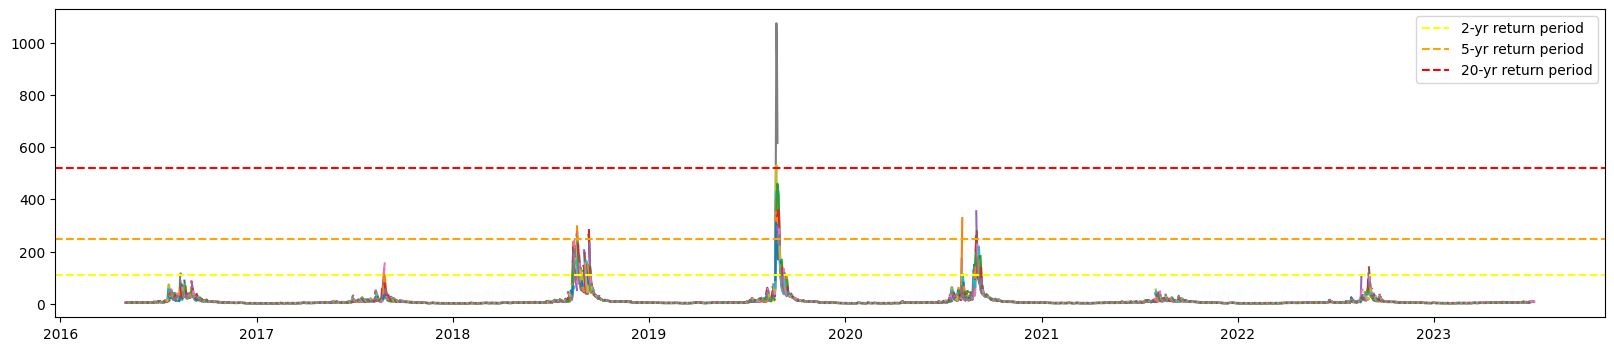

In [13]:
issue_time_start_date = '2016-05-01'
issue_time_end_date = '2024-10-30'

analyse.plot_reforecast(issue_time_start_date, issue_time_end_date,
                        ds_reforecast_example, ds_return_ps_example)

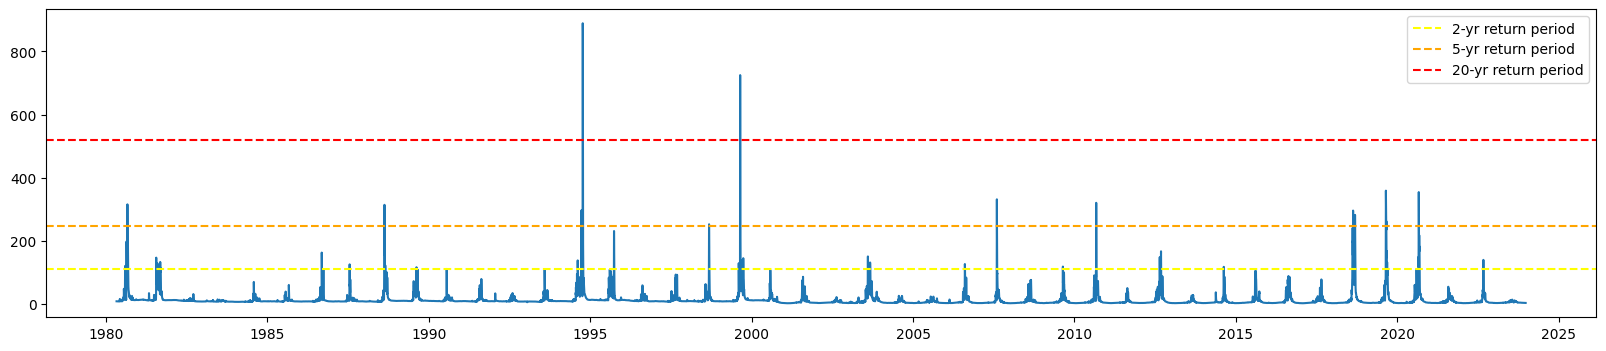

In [14]:
issue_time_start_date = '1980-05-01'
issue_time_end_date = '2024-10-30'

analyse.plot_reanalysis(issue_time_start_date, issue_time_end_date,
                        ds_reanalysis_example, ds_return_ps_example)

## **Preprocessing**

The preprocessing is explained on a high-level here: [INSERT LINK], and broadly consists of:

* adding thresholds (return periods and percentiles);
* [optional] filtering insignificant gauges;
* selecting a lead-time;
* [optional] aggregating into administrative units using shape files;
* creating "events";
* importing ground truth data (and further processing);
* calculate accuracy.

### **(Re)calculating thresholds**

Because not all gauges, i.e. most of the unverified ones, contain return period threshold (or in public phrasing in the UI (https://sites.research.google/floods/), "danger level") information, and because we want to analyse more thresholds than available, we recalculate the thresholds. We use the reanalysis data for the calculations. In the official paper (https://www.nature.com/articles/s41586-024-07145-1), the threshold calculation is done using a Log-Pearson Type III fit; it remains ambiguous, however, on what data and how exactly. Nonetheless, we recalculate using a Gumbel fit.

In [15]:
# add return periods and percentiles to all datasets and create
# a dictionary with all values recalculated (rc) for reference
dict_datasets = \
    analyse.add_RPs_and_percentiles(dict_datasets, dict_reanalysis, ['5'], [], 'Gumbel')

7.21% done
14.42% done
21.63% done
28.85% done
36.06% done
43.27% done
50.48% done
57.69% done
64.90% done
72.12% done
79.33% done
86.54% done
93.75% done
100% done


In [16]:
dict_datasets[key_example]

<xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...
Attributes:
    RP_5:     239.01527224744933

### **Filter insignificant gauges**

As our research focuses on "high-impact gauges" for a theoretically practical response, we filter out datasets which do not fit this purpose. In other words, we set a threshold for filtering some gauges: if the 5-year RP is below 100 $m^3/s$, a gauge is discarded. Since we will chiefly use maxima of the data later, the only real effect of this is some districts now being "left out" as they have no gauge, and a significant speed-up of the calculations.

In [17]:
dict_datasets_non_filtered = dict_datasets.copy()
dict_datasets = {key: value for key, value in dict_datasets.items() if float(value.attrs['RP_5']) >= 100}
dict_reanalysis = {key: value for key, value in dict_reanalysis.items() if key in dict_datasets}

print('Original amount of datasets:            ', len(dict_datasets_non_filtered))
print('Left-over amount of reforecast datasets:', len(dict_datasets))
print('Left-over amount of reanalysis datasets:', len(dict_reanalysis))

Original amount of datasets:             1664
Left-over amount of reforecast datasets: 623
Left-over amount of reanalysis datasets: 623


### **Add quality-verified flag**

Add a the qualityVerified flag from the ListGauges() API-call to the gauge datasets as attribute, for plotting and matching

In [18]:
dict_datasets_non_filtered = analyse.add_quality_verified_flag(dict_datasets_non_filtered, df_Mali_gauges)
dict_datasets = analyse.add_quality_verified_flag(dict_datasets, df_Mali_gauges)
dict_reanalysis = analyse.add_quality_verified_flag(dict_reanalysis, df_Mali_gauges)

### **Checkpoint: adjust comparison type, lead time, or threshold from here**

From here, the script can be ran with different configurations to generate different kinds of plots and metrics, which will all be exported (except for the plots) to the `data/` folder. The options are:

* For comparison type (**COMP_TYPE**): IMPACT or OBS (observation), giving a comparison to either events as entailed by the impact event data or observational timeseries data. Impact data is provided per administrative unit, and to accomodate this, the forecast data is aggregated to this level. Observation data is just station-based.
* For lead time (**LEAD_TIME**), the options are 1 to 7, since the GFH model does a daily 7-day horizon forecast.
* For threshold (**THRESHOLD**), the options are 1.5-, 2-, 5-, 10-year return period thresholds, as calculated through the timeseries maxima, or the 95th, 98th, 99th percentile thresholds, as calculated through daily values. For OBSERVATION though, because we only have 2 years of overlap between the data, we discard more extreme thresholds, i.e. the 10-year one.

One calculation can take up to 30 minutes, depending on processor speed and whether some common precalculations are done (and stored) already.
```
comp_types = ['IMPACT', 'OBS']
thresholds = [1.5, 2, 5, 7, 10, 20, 95, 98, 99]
lead_times = [1, 2, 3, 4, 5, 6, 7]
```

In [19]:
COMP_TYPE = 'IMPACT'
THRESHOLD = 5
LEAD_TIME = 7

Using coordinates gathered through the API, the GRRR dataset, and shape files for Mali's administrative level 2, we assign each gauge dataset an admin unit. A caveat here is that gauges are often located on rivers, and that rivers often form borders between certain regions. As such, an on-border gauge will arbitrarily fall into one of its nearby regions, while a flood at its location will affect all its nearby regions. To account for this, we change a gauge's location from a point to a circle with a radius of 5 km, and all regions that overlap are considered a match.

After this step, the datasets contain a:
* **gauge ID**: unique identifier;
* **quality flag**: whether the gauge's forecasts are "verified" or "unverified"
* **administrative unit ID**: the administrative units te gauge falls into; and
* **coordinates**: a latitude and longitude,

which are assured below.

In [20]:
# Make sure country gauge coords are available (externally) and then assign them
analyse.export_country_gauge_coords(df_Mali_gauges, 'Mali')

dict_datasets = analyse.assign_admin_unit_to_datasets(dict_datasets)
dict_datasets_non_filtered = analyse.assign_admin_unit_to_datasets(dict_datasets_non_filtered)
dict_reanalysis = analyse.assign_admin_unit_to_datasets(dict_reanalysis)

analyse.assure_attributes_assigned(dict_datasets)
analyse.assure_attributes_assigned(dict_datasets_non_filtered)
analyse.assure_attributes_assigned(dict_reanalysis)

In [21]:
print(dict_datasets[key_example])

<xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...
Attributes:
    RP_5:             239.01527224744933
    qualityVerified:  False
    latitude:         16.552083333332178
    longitude:        -4.918750000002717
    gauge_id:         1120040380
    admin_unit:       ['ML0602']


In [22]:
print('n administrative units in reforecasts datasets:', analyse.count_admin_units(dict_datasets))
print('n gauges datasets:                             ', analyse.count_gauge_ids(dict_datasets))
print(f'{(analyse.count_admin_units(dict_datasets) / analyse.count_gauge_ids(dict_datasets) - 1) * 100:.2f}%'
       ' "more" assigned administrative units than gauges')

n administrative units in reforecasts datasets: 865
n gauges datasets:                              623
38.84% "more" assigned administrative units than gauges


### **Aggregate over districts**

In case of a ground truth that has a spatial resolution of "districts," one can aggregate the forecasts to this resolution.

We aggregate the data per admin unit and create a dataset with just the maximum value of the reforecast data at each possible timestep available in the datasets for each admin units (resulting in one dataset per admin unit).

In [23]:
# aggregate the data per gauge to per admin unit if not done already
dict_datasets_au = analyse.aggregate_or_load_per_admin_unit(
    dict_datasets, dict_reanalysis, LEAD_TIME
)

Checking if datasets are already loaded...
Loading in datasets...
Loading complete


Plot to visualise the aggregated data for a certain admin unit by plotting the individual and aggregated hydrographs in/of the unit

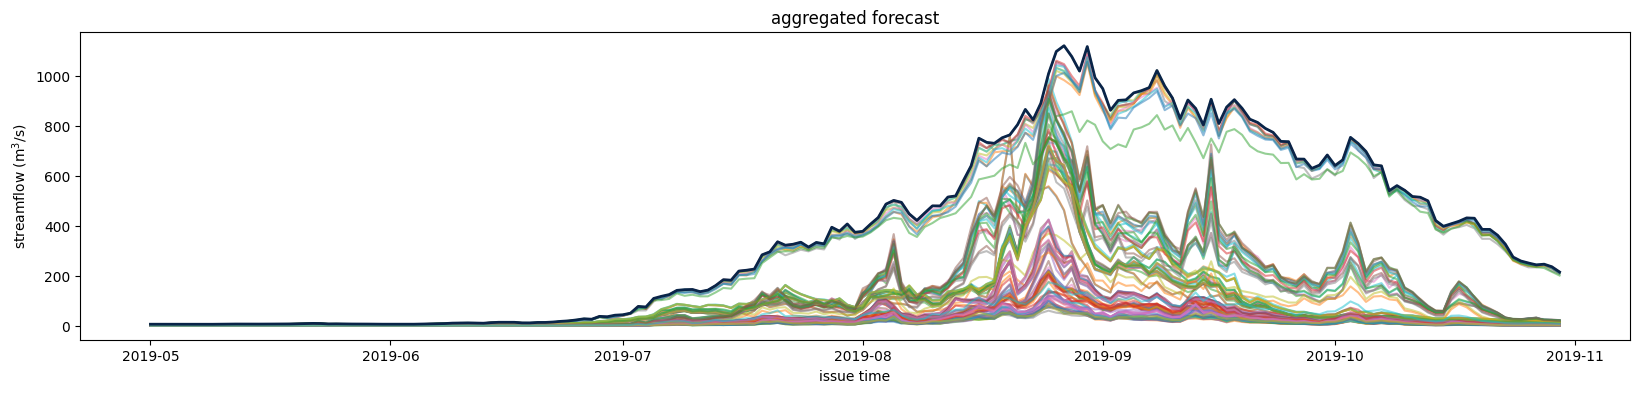

In [24]:
l_gauges_xth_admin_unit, admin_unit_xth_gauges = \
    analyse.get_datasets_for_xth_admin_unit(dict_datasets_au, dict_datasets, x = 1)

analyse.plot_aggregated_reforecast('2019-05-01', '2019-10-30',
                           l_gauges_xth_admin_unit,
                           dict_datasets_au[admin_unit_xth_gauges])

### **Import and preprocess ground truth data**

Here's an appropriate spot to load in and preprocess ground truth data. See ``GRRR_Mali.ipynb`` or https://github.com/rodekruis/disaster-impact-data-analysis for examples.

### **Create events**

With datasets (per admin unit) ready, we loop through them to create "flood events": periods of consecutive flooding in an administrative unit. A flood event is "triggered" once the maximum chosen lead time (LEAD_TIME) predicted discharge in an administrative unit surpasses the return period threshold (THRESHOLD) for more than one day. Depending on the ground truth of choice, these can be compared to impact events (IMPACT) or observation events (OBSERVATION) to determine overlap, e.g. through boolean masking, and calculate metrics. Ideally, for reasons such as computational efficiency, flood events are already subsetted before this step in accordance with the ground truth data of interest.

Creating flood events starts with combining the forecast timeseries ($Q(t)$) and a threshold ($Q_{th}$) into a boolean mask per timestep, with **True** / **False** for $Q(t) >= Q_{th}$ and $Q(t) < Q_{th}$, respectively.

If the flood is just one day, i.e. only one consecutive **True** value is encountered, the river is assumed to handle the water itself. If not, a flood event is created and stored in a DataFrame per administrative unit or station (depending on assessing impact data or observational data) accessible with the corresponding identifier.

Finally, note that the flood events are already calculated by their "actual date," hence, we export it using LEAD_TIME (* 24 hours) as lead time identifier.

In [27]:
if COMP_TYPE == 'IMPACT':
    dict_flood_events = analyse.create_flood_events(dict_datasets_au, True, THRESHOLD)
elif COMP_TYPE == 'OBS':
    dict_flood_events = analyse.create_flood_events(dict_datasets, True, THRESHOLD)
else:
    raise ValueError('COMP_TYPE must be either "IMPACT" or "OBS"')
analyse.export_dict_flood_events_to_csv(dict_flood_events, THRESHOLD, LEAD_TIME)

exporting 143 flood events to csv


In [44]:
print(dict_flood_events[list(dict_flood_events.keys())[0]])

  flood_start  flood_end  duration  peak_streamflow
0  2018-09-07 2018-09-22        16      1477.674194
1  2019-09-01 2019-09-16        16      1275.597534
2  2020-09-08 2020-10-03        26      1687.966431


In [45]:
import sys
sys.exit()

SystemExit: 

C:\Users\vwold\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## **Calculate overlap and metrics**

We can now calculate the performance of the model by comparing the
flood events to the impact events, and we will do this by calculating
the following metrics:
* **True Positives (TP)**: the number of correctly predicted flood events;
* **False Positives (FP)**: the number of incorrectly predicted flood events; and
* **False Negatives (FN)**: the number of missed flood events,

and with these a bunch of other metrics such as:
* **Precision**: TP / (TP + FP);
* **Probability of Detection (POD) / Recall**: TP / (TP + FN);
* **F1-score**: 2 * Precision * Recall / (Precision + Recall); and
* **False Alarm Rate (FAR)**: FP / (TP + FP).

Because we're comparing one "type" of event only, we have a sort of "one-class classification" or "anamoly detection", and therefore no True Negatives (TN).

In [ ]:
# # select dictionary of ground truth events based on type
# if COMP_TYPE == 'IMPACT':
#     dict_comp = dict_impact_events_final
# elif COMP_TYPE == 'OBS':
#     dict_comp = dict_obs_events_final

# # margin of error for the comparison of dates; argumentation for this
# # can be that the impact data is inexact and that for practical preparation-
# # wise purposes, a little margin of error does not make a big difference
# action_lifetime = 10 # also called the margin of error
# df_metrics = match_events_and_get_metrics(dict_flood_events_final,
#                                           dict_comp,
#                                           action_lifetime)
# # note that when action_lifetime is set to an arbitrarily large number such as
# # 10000, you'd expect only true positives, but that's not the case, since there
# # might be impact events for which *the* threshold is not passed within those
# # 10000 days, i.e. when the threshold is so high it is not passed within the timeframe
# inevitable_FNs = sum([len(dict_comp[admin_unit]) for admin_unit in \
#                       dict_comp.keys() if admin_unit not in dict_flood_events_final])
# print(f'Admin units with impact data without a flood event for threshold {THRESHOLD} is',
#       len(dict_comp.keys()) - len(dict_flood_events_final.keys()),
#       f'\nleading to {inevitable_FNs} inevitable False Negatives')
# print()

# export_results(df_metrics, COMP_TYPE, LEAD_TIME, THRESHOLD)
# print(df_metrics)

Admin units with impact data without a flood event for threshold 5 is -5 
leading to 0 inevitable False Negatives

       identifier  TP  FP  FN    POD    FAR  precision     f1
0         Ansongo   1   2   1  0.500  0.667      0.333  0.400
1   Bafing Makana   0   2   0    NaN  1.000      0.000    NaN
2          Bamako   1   3   0  1.000  0.750      0.250  0.400
3       Banankoro   1   3   0  1.000  0.750      0.250  0.400
4        Bougouni   1   2   0  1.000  0.667      0.333  0.500
5            Dire   0   4   0    NaN  1.000      0.000    NaN
6           Douna   1   3   1  0.500  0.750      0.250  0.333
7             Gao   0   2   0    NaN  1.000      0.000    NaN
8    Guelelinkoro   0   4   0    NaN  1.000      0.000    NaN
9           Kayes   0   4   0    NaN  1.000      0.000    NaN
10      Koulikoro   1   4   0  1.000  0.800      0.200  0.333
11          Mopti   1   2   1  0.500  0.667      0.333  0.400
12      Pankourou   1   4   1  0.500  0.800      0.200  0.286
13         Sofara

In [ ]:
analyse.export_all_results_to_geojson('../data/results', '../data/results_geojson')

## **Automatically generate all metrics**

It is recommended to loop through all the possible configurations at the "checkpoint" using the cell below here (because we're in a notebook) to automatically generate all results. Commented out by default.

In [ ]:
# comp_types = ['IMPACT', 'OBS']
# thresholds = [1.5, 2, 5, 10, 95, 98, 99]
# lead_times = [1, 2, 3, 4, 5, 6, 7]

# for comp_type in comp_types:
#     for th in thresholds:
#         for lt in lead_times:
#             COMP_TYPE = comp_type
#             THRESHOLD = th
#             LEAD_TIME = lt
#             print(f'\n\n\t{comp_type}: calculating metrics for threshold',
#                   THRESHOLD, 'and lead time', LEAD_TIME, '\n\n')

#             print('Computing...')
            
#             print('\n\n\t\tCalculated metrics for threshold', THRESHOLD, 'and lead time', LEAD_TIME, '\n\n')



	IMPACT: calculating metrics for threshold 1.5 and lead time 1 


Computing...


		Calculated metrics for threshold 1.5 and lead time 1 




	IMPACT: calculating metrics for threshold 1.5 and lead time 2 


Computing...


		Calculated metrics for threshold 1.5 and lead time 2 




	IMPACT: calculating metrics for threshold 1.5 and lead time 3 


Computing...


		Calculated metrics for threshold 1.5 and lead time 3 




	IMPACT: calculating metrics for threshold 1.5 and lead time 4 


Computing...


		Calculated metrics for threshold 1.5 and lead time 4 




	IMPACT: calculating metrics for threshold 1.5 and lead time 5 


Computing...


		Calculated metrics for threshold 1.5 and lead time 5 




	IMPACT: calculating metrics for threshold 1.5 and lead time 6 


Computing...


		Calculated metrics for threshold 1.5 and lead time 6 




	IMPACT: calculating metrics for threshold 1.5 and lead time 7 


Computing...


		Calculated metrics for threshold 1.5 and lead time 7 




	IMPACT: ca